In [1]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import pandas as pd
import os
import tensorflow.keras.losses
import math
import datetime

In [2]:
#Loads in the proper model
model_name='run6_24_grayscale'
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
model=models.load_model(os.path.join('Models',model_name),compile=False)
model.compile(optimizer='Adam', loss=root_mean_squared_error, metrics=['mse','mae'])

In [4]:
#Sets the directory for the training set and the eventual prediction file
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_6_23'
os.makedirs(os.path.join("Training_Set_Predictions",model_name))
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))

#Creates a generator that feeds images with no labels into the predict method
batch_size=256
predict_test_datagen=ImageDataGenerator(rescale=1./255)
predict_test_generator=predict_test_datagen.flow_from_dataframe(
    dft,
    directory=test_dataset_dir,
    x_col="filename",
    target_size=(32,32),
    color_mode='grayscale',
    shuffle=False,
    class_mode=None,
    batch_size=batch_size
    )


Found 300000 validated image filenames.


In [5]:
#Generates predictons for all images in the training directory. Saves these predictions to a pandas dataframe
im_names=dft['filename'].to_numpy().tolist()
central_atom_x_labels=[]
central_atom_y_labels=[]
neighbor_vect_1_x_labels=[]
neighbor_vect_1_y_labels=[]
neighbor_vect_2_x_labels=[]
neighbor_vect_2_y_labels=[]
neighbor_vect_3_x_labels=[]
neighbor_vect_3_y_labels=[]

prediction=model.predict(predict_test_generator,verbose=1)

for p in prediction:
    central_atom_x_labels.append(p[0])
    central_atom_y_labels.append(p[1])
    neighbor_vect_1_x_labels.append(p[2])
    neighbor_vect_1_y_labels.append(p[3])
    neighbor_vect_2_x_labels.append(p[4])
    neighbor_vect_2_y_labels.append(p[5])
    neighbor_vect_3_x_labels.append(p[6])
    neighbor_vect_3_y_labels.append(p[7])

data={
    'filename':im_names,'x_coord':central_atom_x_labels,'y_coord':central_atom_y_labels, 
    'neighbor1x':neighbor_vect_1_x_labels, 'neighbor1y':neighbor_vect_1_y_labels,
    'neighbor2x':neighbor_vect_2_x_labels, 'neighbor2y':neighbor_vect_2_y_labels,
    'neighbor3x':neighbor_vect_3_x_labels, 'neighbor3y':neighbor_vect_3_y_labels,
    }
df=pd.DataFrame(data)
#df.to_csv("predictions_dataframe.csv",index=False)
df.to_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"),index=False)

1172/1172 [==============================] - 163s 139ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'Training_Set_Predictions\\run6_24_grayscale\\predictions_dataframe.csv'

In [7]:
#Method for separting label array into useful data points
def split_label(labels):
    center_atom=np.array([labels[0],labels[1]])*32
    neighborvec1=np.array([labels[2],labels[3]])*32
    neighborvec2=np.array([labels[4],labels[5]])*32
    neighborvec3=np.array([labels[6],labels[7]])*32
    neighbors=[]
    neighbors.append(center_atom+neighborvec1)
    neighbors.append(center_atom+neighborvec2)
    neighbors.append(center_atom+neighborvec3)
    return center_atom , neighbors 

#Methods for coloring in the central atom and labels on the images.
def plot_labels():
    plt.plot(center_atom[0],center_atom[1],'o',color='white')
    plt.plot(neighbors[0][0],neighbors[0][1],'o',color='red')
    plt.plot(neighbors[1][0],neighbors[1][1],'o',color='green')
    plt.plot(neighbors[2][0],neighbors[2][1],'o',color='blue')

def plot_test_labels():
    plt.plot(center_atom_t[0],center_atom_t[1],'o',color='xkcd:beige')
    plt.plot(neighbors_t[0][0],neighbors_t[0][1],'o',color='xkcd:dark red')
    plt.plot(neighbors_t[1][0],neighbors_t[1][1],'o',color='xkcd:dark green')
    plt.plot(neighbors_t[2][0],neighbors_t[2][1],'o',color='xkcd:dark blue')


<function matplotlib.pyplot.show(*args, **kw)>

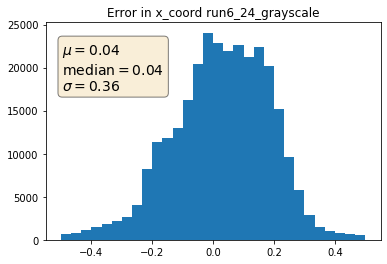

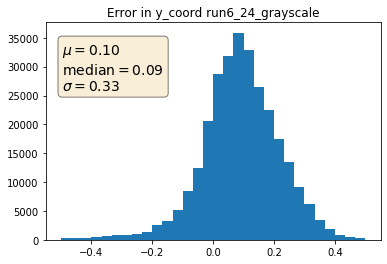

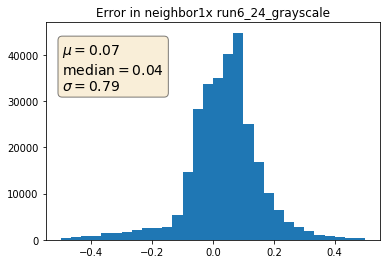

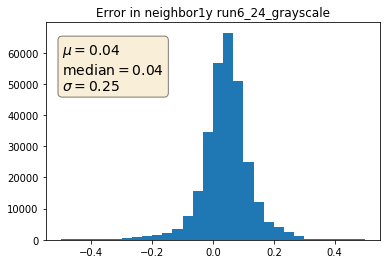

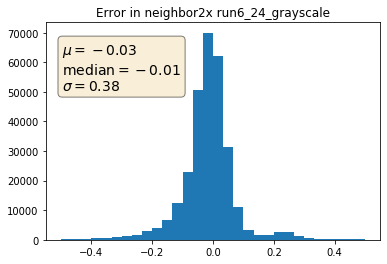

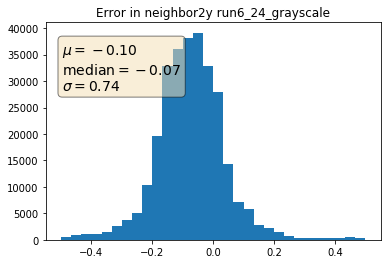

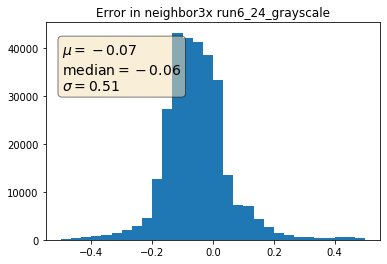

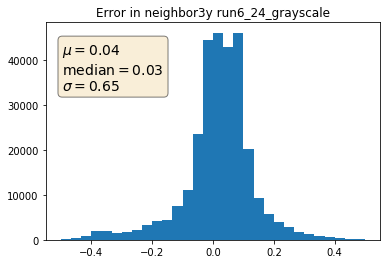

<Figure size 432x288 with 0 Axes>

In [11]:
#Calculates the error between the predictions and labels for a given model on a dataset. Plots histograms of the error and saves the results
model_name='run6_24_grayscale'
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_6_23'
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))
dfp= pd.read_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"))

def get_error(column):
    diff= (dft[column].to_numpy()-dfp[column].to_numpy())*32
    return diff

def get_metrics(data):
    return data.mean(), np.median(data), data.std()
#os.makedirs(os.path.join('Prediction_Plots',model_name))
plot_dir=os.path.join('Prediction_Plots',model_name)

error_x=get_error('x_coord')
error_y=get_error('y_coord')
error_neighbor1x=get_error('neighbor1x')
error_neighbor1y=get_error('neighbor1y')
error_neighbor2x=get_error('neighbor2x')
error_neighbor2y=get_error('neighbor2y')
error_neighbor3x=get_error('neighbor3x')
error_neighbor3y=get_error('neighbor3y')


props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
mu, median, sigma =get_metrics(error_x)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.hist(error_x,bins=30,range=(-0.5,0.5))
plt.title('Error in x_coord '+ model_name)
#plt.savefig(os.path.join(plot_dir,model_name+" error_x.png"))
plt.figure()

mu, median, sigma =get_metrics(error_y)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.hist(error_y,bins=30,range=(-0.5,0.5))
plt.title('Error in y_coord '+ model_name)
#plt.savefig(os.path.join(plot_dir,model_name+" error_y.png"))
plt.figure()

mu, median, sigma =get_metrics(error_neighbor1x)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.hist(error_neighbor1x,bins=30,range=(-0.5,0.5))
plt.title('Error in neighbor1x '+ model_name)
#plt.savefig(os.path.join(plot_dir,model_name+" error_neighbor1x.png"))
plt.figure()

mu, median, sigma =get_metrics(error_neighbor1y)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.hist(error_neighbor1y,bins=30,range=(-0.5,0.5))
plt.title('Error in neighbor1y '+ model_name)
#plt.savefig(os.path.join(plot_dir,model_name+" error_neighbor1y.png"))
plt.figure()

mu, median, sigma =get_metrics(error_neighbor2x)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.hist(error_neighbor2x,bins=30,range=(-0.5,0.5))
plt.title('Error in neighbor2x '+ model_name)
#plt.savefig(os.path.join(plot_dir,model_name+" error_neighbor2x.png"))
plt.figure()

mu, median, sigma =get_metrics(error_neighbor2y)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.hist(error_neighbor2y,bins=30,range=(-0.5,0.5))
plt.title('Error in neighbor2y '+ model_name)
#plt.savefig(os.path.join(plot_dir,model_name+" error_neighbor2y.png"))
plt.figure()

mu, median, sigma =get_metrics(error_neighbor3x)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.hist(error_neighbor3x,bins=30,range=(-0.5,0.5))
plt.title('Error in neighbor3x '+ model_name)
#plt.savefig(os.path.join(plot_dir,model_name+" error_neighbor3x.png"))
plt.figure()

mu, median, sigma =get_metrics(error_neighbor3y)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.hist(error_neighbor3y,bins=30,range=(-0.5,0.5))
plt.title('Error in neighbor3y '+ model_name)
#plt.savefig(os.path.join(plot_dir,model_name+" error_neighbor3y.png"))
plt.figure()

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

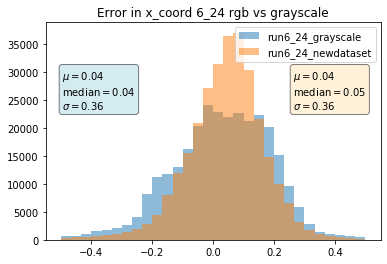

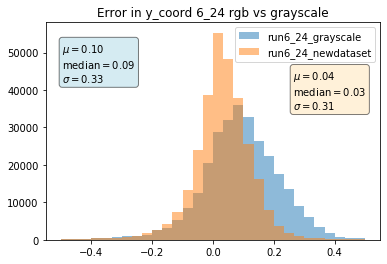

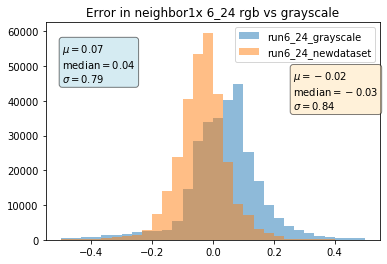

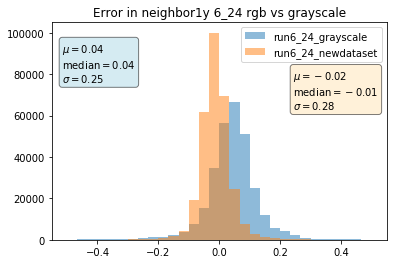

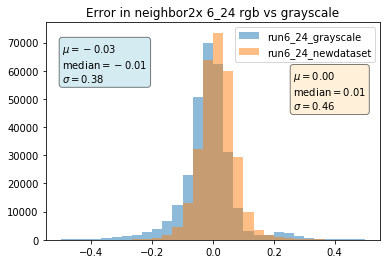

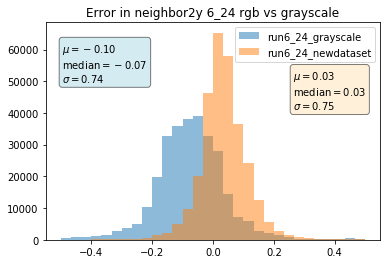

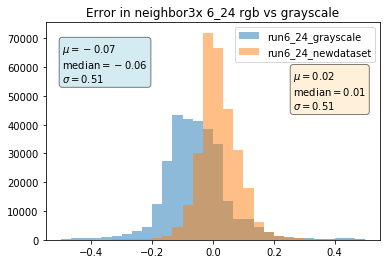

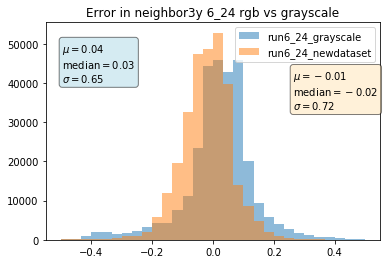

<Figure size 432x288 with 0 Axes>

In [35]:
#Code for comparing two models. Calculates the error between the predictions and labels for a given model on a dataset. Plots histograms of the error and saves the results
graph_name='6_24 rgb vs grayscale'
model_name='run6_24_grayscale'
model_name_2='run6_24_newdataset'
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_6_23'
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
prediction_dir_2=os.path.join("Training_Set_Predictions",model_name_2)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))
dfp= pd.read_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"))
dfp_2= pd.read_csv(os.path.join(prediction_dir_2,"predictions_dataframe.csv"))

def get_error(column):
    diff= (dft[column].to_numpy()-dfp[column].to_numpy())*32
    return diff

def get_error_2(column):
    diff= (dft[column].to_numpy()-dfp_2[column].to_numpy())*32
    return diff

def get_metrics(data):
    return data.mean(), np.median(data), data.std()
#os.makedirs(os.path.join('Prediction_Plots',graph_name))
plot_dir=os.path.join('Prediction_Plots',graph_name)

error_x=get_error('x_coord')
error_y=get_error('y_coord')
error_neighbor1x=get_error('neighbor1x')
error_neighbor1y=get_error('neighbor1y')
error_neighbor2x=get_error('neighbor2x')
error_neighbor2y=get_error('neighbor2y')
error_neighbor3x=get_error('neighbor3x')
error_neighbor3y=get_error('neighbor3y')

error_x_2=get_error_2('x_coord')
error_y_2=get_error_2('y_coord')
error_neighbor1x_2=get_error_2('neighbor1x')
error_neighbor1y_2=get_error_2('neighbor1y')
error_neighbor2x_2=get_error_2('neighbor2x')
error_neighbor2y_2=get_error_2('neighbor2y')
error_neighbor3x_2=get_error_2('neighbor3x')
error_neighbor3y_2=get_error_2('neighbor3y')


props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
props_2 = dict(boxstyle='round', facecolor='moccasin', alpha=0.5)


mu, median, sigma =get_metrics(error_x)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))

plt.text(.05, 0.55, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
mu, median, sigma =get_metrics(error_x_2)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.90, 0.55, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props_2)
plt.hist(error_x,bins=30,range=(-0.5,0.5),alpha=.5,label=model_name)
plt.hist(error_x_2,bins=30,range=(-0.5,0.5),alpha=.5,label=model_name_2)
plt.legend(loc="upper right")
plt.title('Error in x_coord '+ graph_name)
plt.savefig(os.path.join(plot_dir,"error_x.png"))
plt.figure()



mu, median, sigma =get_metrics(error_y)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
mu, median, sigma =get_metrics(error_y_2)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.90, 0.55, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props_2)
plt.hist(error_y,bins=30,range=(-0.5,0.5),alpha=0.5,label=model_name)
plt.hist(error_y_2,bins=30,range=(-0.5,0.5),alpha=0.5,label=model_name_2)
plt.title('Error in y_coord '+ graph_name)
plt.legend(loc="upper right")
plt.savefig(os.path.join(plot_dir,"error_y.png"))
plt.figure()



mu, median, sigma =get_metrics(error_neighbor1x)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
mu, median, sigma =get_metrics(error_neighbor1x_2)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.90, 0.55, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props_2)
plt.hist(error_neighbor1x,bins=30,range=(-0.5,0.5),alpha=0.5,label=model_name)
plt.hist(error_neighbor1x_2,bins=30,range=(-0.5,0.5),alpha=0.5,label=model_name_2)
plt.title('Error in neighbor1x '+ graph_name)
plt.legend(loc="upper right")
plt.savefig(os.path.join(plot_dir,"error_neighbor1x.png"))
plt.figure()



mu, median, sigma =get_metrics(error_neighbor1y)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
mu, median, sigma =get_metrics(error_neighbor1y_2)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.90, 0.55, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props_2)
plt.hist(error_neighbor1y,bins=30,range=(-0.5,0.5),alpha=0.5,label=model_name)
plt.hist(error_neighbor1y_2,bins=30,range=(-0.5,0.5),alpha=0.5,label=model_name_2)
plt.title('Error in neighbor1y '+ graph_name)
plt.legend(loc="upper right")
plt.savefig(os.path.join(plot_dir,"error_neighbor1y.png"))
plt.figure()



mu, median, sigma =get_metrics(error_neighbor2x)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
mu, median, sigma =get_metrics(error_neighbor2x_2)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.90, 0.55, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props_2)
plt.hist(error_neighbor2x,bins=30,range=(-0.5,0.5),alpha=0.5,label=model_name)
plt.hist(error_neighbor2x_2,bins=30,range=(-0.5,0.5),alpha=0.5,label=model_name_2)
plt.title('Error in neighbor2x '+ graph_name)
plt.legend(loc="upper right")
plt.savefig(os.path.join(plot_dir,"error_neighbor2x.png"))
plt.figure()



mu, median, sigma =get_metrics(error_neighbor2y)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
mu, median, sigma =get_metrics(error_neighbor2y_2)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.90, 0.55, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props_2)
plt.hist(error_neighbor2y,bins=30,range=(-0.5,0.5),alpha=0.5,label=model_name)
plt.hist(error_neighbor2y_2,bins=30,range=(-0.5,0.5),alpha=0.5,label=model_name_2)
plt.title('Error in neighbor2y '+ graph_name)
plt.legend(loc="upper right")
plt.savefig(os.path.join(plot_dir,"error_neighbor2y.png"))
plt.figure()



mu, median, sigma =get_metrics(error_neighbor3x)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
mu, median, sigma =get_metrics(error_neighbor3x_2)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.90, 0.55, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props_2)
plt.hist(error_neighbor3x,bins=30,range=(-0.5,0.5),alpha=0.5,label=model_name)
plt.hist(error_neighbor3x_2,bins=30,range=(-0.5,0.5),alpha=0.5,label=model_name_2)
plt.title('Error in neighbor3x '+ graph_name)
plt.legend(loc="upper right")
plt.savefig(os.path.join(plot_dir,"error_neighbor3x.png"))
plt.figure()



mu, median, sigma =get_metrics(error_neighbor3y)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.05, 0.65, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
mu, median, sigma =get_metrics(error_neighbor3y_2)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
plt.text(.90, 0.55, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props_2)
plt.hist(error_neighbor3y,bins=30,range=(-0.5,0.5),alpha=0.5,label=model_name)
plt.hist(error_neighbor3y_2,bins=30,range=(-0.5,0.5),alpha=0.5,label=model_name_2)
plt.title('Error in neighbor3y '+ graph_name)
plt.legend(loc="upper right")
plt.savefig(os.path.join(plot_dir,"error_neighbor3y.png"))
plt.figure()



plt.show

In [3]:
# NOTICE: will only work with the datasets created using for loops, not for the random datasets
bl_list=np.linspace(7,9,num=4)
offx_list=np.linspace(-5,5,num=5)
offy_list=np.linspace(-5,5,num=5)
atom_size_list=np.linspace(2,3.5,num=3)
q_list=np.linspace(0,.1,num=5)
r_list=np.linspace(0,.1,num=5)
b_list=np.linspace(0,.1,num=5)
angle_list=np.linspace(-30,30,num=8)
#Returns the filename of a given image in the dataframe. Inputs are NOT the values of the parameters, they are the indicies, asking for the i'th value of each parameter. ie _bl=3 means the 4th value bl can take in the dataset
def get_filename(_bl,_offx,_offy,_a_s,_q,_r,_b,_angle):
    bl=bl_list[_bl]
    offx=offx_list[_offx]
    offy=offy_list[_offy]
    atom_size=atom_size_list[_a_s]
    q=q_list[_q]
    r=r_list[_r]
    b=b_list[_b]
    angle=angle_list[_angle]
    filename=f"bl{str(bl).replace('.','').replace('-','neg')}_offx{str(offx).replace('.','').replace('-','neg')}_offy{str(offy).replace('.','').replace('-','neg')}_as{str(atom_size).replace('.','')}_strain{str(q).replace('.','')}{str(r).replace('.','')}{str(b).replace('.','')}_angle{str(angle).replace('.','').replace('-','neg')}.png"
    return filename


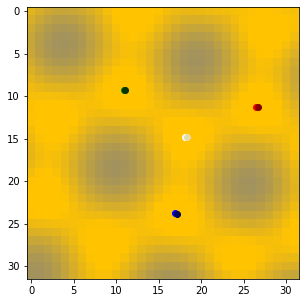

In [36]:
#Loads in a single testing image and plots its prediction vs true labels
model_name='run6_24_grayscale'
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_6_23'
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))
dfp= pd.read_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"))
#get_filename params are the indicies for (bond length, offx, offy, atom size, q, r, b, anlge)
#im_filename=get_filename(3,0,4,1,0,2,0,3)
#print(im_filename)
#index=np.flatnonzero(dft['filename']==im_filename)[0]
index=27742

test_im=image.load_img(os.path.join(test_dataset_dir,dft['filename'][index]))
test_im_arr=image.img_to_array(test_im)
test_im_arr_batch=np.array([test_im_arr])
label_names=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y']
test_labels=dft[label_names].loc[index].to_numpy()
prediction_labels=dfp[label_names].loc[index].to_numpy()

center_atom_t,neighbors_t=split_label(test_labels)
center_atom,neighbors=split_label(prediction_labels)

prediction_plots_dir=os.path.join('Prediction_Plots',datetime.datetime.now().strftime("%m_%d"))

fig = plt.figure(figsize = (5, 5))
ax = plt.subplot(1,1,1)
ax.imshow(test_im)
plot_labels()
plot_test_labels()
#plt.savefig(os.path.join(prediction_plots_dir,"train_image_"+str(index)+"_"+model_name))

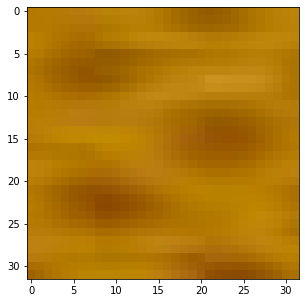

In [22]:
#Loads in real STM images and crops them. Rescales cropped image to 32x32
def crop_STM(arr,xy,size):
    x,y = xy
    return arr[y:y+size,x:x+size]
image_offset=[155,71]
image_size=20
croping_box=(image_offset[0],image_offset[1],image_offset[0]+image_size,image_offset[1]+image_size)
im=image.load_img("MoC2 _ 349.jpg")
im_crop=im.crop(croping_box)
im_resize=im_crop.resize((32,32))
# im_arr=crop_STM(im_arr,image_offset,32)
# im_arr=np.array(Image.fromarray(im_arr).resize((32,32)))
im_arr=image.img_to_array(im_resize).astype('int')
im_arr_batch=np.array([im_arr])
plt.figure(figsize = (5, 5))
ax = plt.subplot(1,1,1)
ax.imshow(im_arr)

In [23]:
#Generator and predictor for real STM image. 
#Creates data generators to load images into the model
predict_datagen = ImageDataGenerator(rescale=1./255) 
predict_generator= predict_datagen.flow(
    im_arr_batch,
    batch_size=1
    )

#uses the model to predict center atom and neighbors, assigns locations and vectors accordingly
prediction=model.predict(predict_generator)
prediction=prediction[0]

#assingns relevant datapoints
center_atom,neighbors=split_label(prediction)

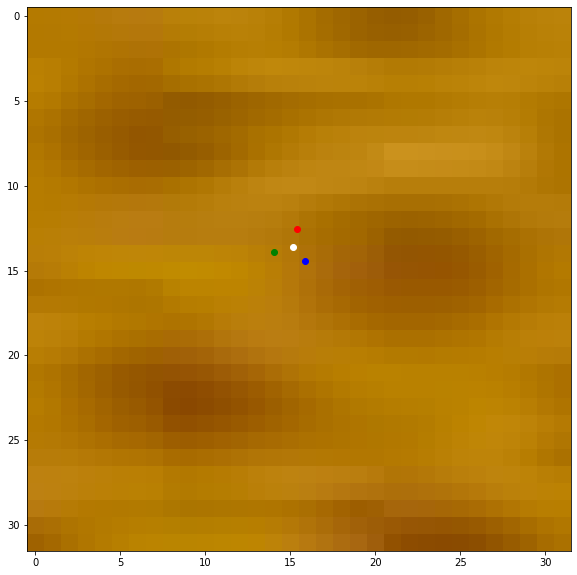

In [24]:
#Plots the predictions on the STM image
prediction_plots_dir=os.path.join('Prediction_Plots',datetime.datetime.now().strftime("%m_%d"))

fig = plt.figure(figsize = (10, 10))
ax = plt.subplot(1,1,1)
ax.imshow(im_arr)
plot_labels()
#plt.savefig(os.path.join(prediction_plots_dir,"real_image_test_bad_ex"+model_name))